# Titanic passenger survival prediction - Solution
Questo notebook mostra come costruire un modello di machine learning per prevedere la sopravvivenza dei passeggeri del Titanic.
# Dataset e obiettivi
Utilizzeremo il dataset Titanic, che è un dataset classico per la classificazione binaria. 
Il nostro obiettivo è prevedere se un passeggero è sopravvissuto o meno in base a diverse caratteristiche.

Di sotto la mia proposta.

In [71]:
# Importing the necessary libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import KNNImputer, IterativeImputer, SimpleImputer
from sklearn.preprocessing import LabelEncoder

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
%config InlineBackend.figure_format = "retina"
sns.set()

# Load dataset

In [72]:
# Caricamento del dataset
titanic_sub = pd.read_csv("titanic_sub.csv")

In [73]:
#Analisi del dataframe
print(titanic_sub.shape)

(891, 6)


In [74]:
#Ora controlliamo per i valori nulli sia in valori assoluti che in percentuale per aiutarci a capire la qualità dei dati
nulli_assoluti = titanic_sub.isnull().sum()
print("Valori nulli per colonna (assoluti):")
print(nulli_assoluti)
nulli_percentuali = (titanic_sub.isnull().sum() / titanic_sub.shape[0]) * 100
print("\nValori nulli per colonna (percentuale):")
print(nulli_percentuali.round(2).astype(str) + "%")

Valori nulli per colonna (assoluti):
PassengerId      0
Sex              0
Age            177
Pclass           0
Embarked         2
Survived         0
dtype: int64

Valori nulli per colonna (percentuale):
PassengerId      0.0%
Sex              0.0%
Age            19.87%
Pclass           0.0%
Embarked        0.22%
Survived         0.0%
dtype: object


In [75]:
# Per decidere come trattare i valori nulli, possiamo visualizzare le statistiche descrittive del dataset
titanic_sub.info(memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Sex          891 non-null    object 
 2   Age          714 non-null    float64
 3   Pclass       891 non-null    int64  
 4   Embarked     889 non-null    object 
 5   Survived     891 non-null    int64  
dtypes: float64(1), int64(3), object(2)
memory usage: 118.2 KB


In [76]:
titanic_sub.describe(include=object)


,Sex,Embarked
count,891,889
unique,2,3
top,male,S
freq,577,644


In [77]:
titanic_sub.describe()


,PassengerId,Age,Pclass,Survived
count,891.000000,714.000000,891.000000,891.000000
mean,446.000000,29.699118,2.308642,0.383838
std,257.353842,14.526497,0.836071,0.486592
min,1.000000,0.420000,1.000000,0.000000
25%,223.500000,20.125000,2.000000,0.000000
50%,446.000000,28.000000,3.000000,0.000000
75%,668.500000,38.000000,3.000000,1.000000
max,891.000000,80.000000,3.000000,1.000000


# Bilanciamento delle classi
Prima di toccare i dati e il nostro dataset, analizziamo le classi e controlliamo se sono presenti tendenze di cui non siamo a conoscenza.

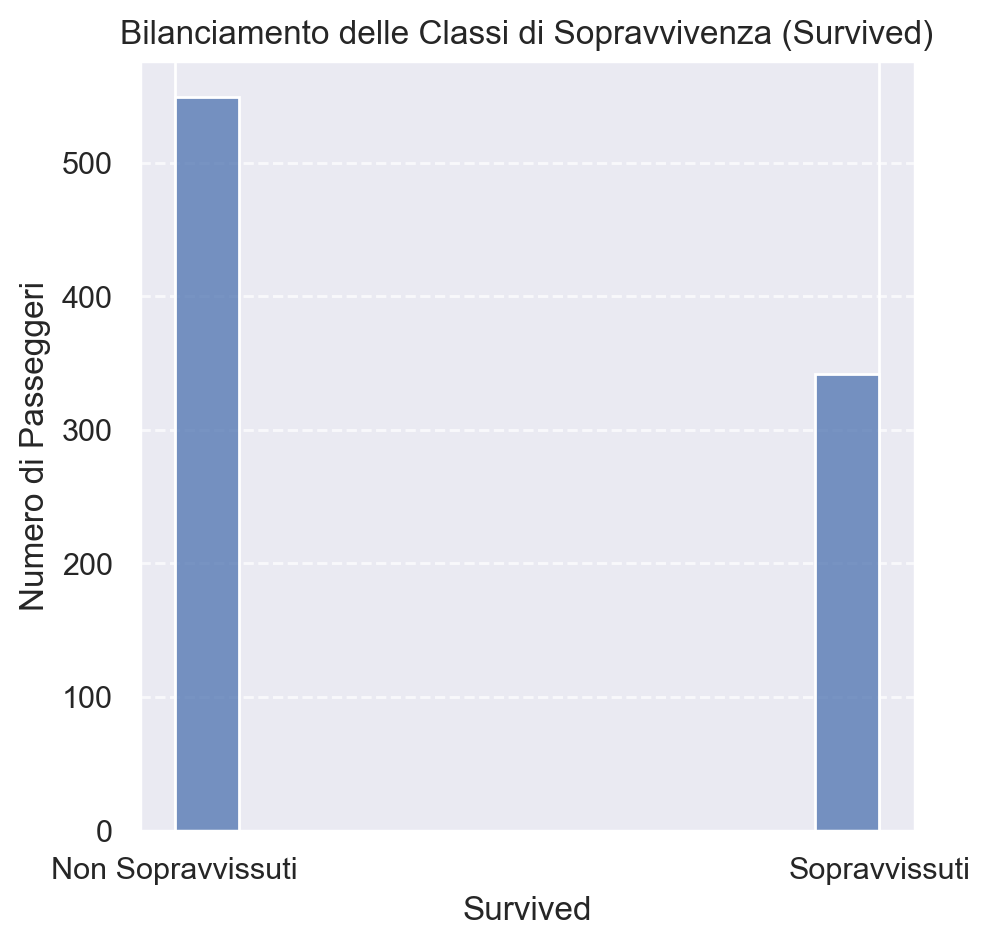

In [78]:
plt.figure(figsize=(5, 5)) # Imposta le dimensioni del grafico
sns.histplot(titanic_sub, x="Survived")
plt.title('Bilanciamento delle Classi di Sopravvivenza (Survived)') # Titolo del grafico
plt.ylabel('Numero di Passeggeri') # Etichetta asse Y
plt.xticks(ticks=[0, 1], labels=['Non Sopravvissuti', 'Sopravvissuti']) # Etichette personalizzate per l'asse X
plt.grid(axis='y', linestyle='--', alpha=0.7) # Aggiunge una griglia leggera
plt.show()

Possiamo notare un notevole distacco fra i due valori, controlliamo la differenza anche numericamente calcolandone la percentuale.

In [79]:
for category in titanic_sub.Survived.unique():
    percentage = (len(titanic_sub[titanic_sub.Survived == category])/len(titanic_sub))*100
    print(f"Percentuale di \033[1m{category}\033[0m a confronto con il totale degli elementi: {percentage:.2f}")

Percentuale di 0 a confronto con il totale degli elementi: 61.62
Percentuale di 1 a confronto con il totale degli elementi: 38.38


# Variabili categoriche e numeriche
Ora identifichiamo fra le variabili in nostro possesso quali sono categoriche e quali numeriche.

In [80]:
numeric_variables = [col for col in titanic_sub.drop("Survived", axis=1).select_dtypes(include=['int', 'float'])]
print(f"Number of numerical features: {len(numeric_variables)}\n")

numeric_variables.pop(0) # Rimuoviamo PassengerId poiché non è una feature utile.
numeric_variables

Number of numerical features: 3



['Age', 'Pclass']

In [81]:
categorical_variables = [col for col in titanic_sub.select_dtypes(include=['object'])]
print(f"Number of categorical features: {len(categorical_variables)}\n")

categorical_variables

Number of categorical features: 2



['Sex', 'Embarked']

Successivamente unificheremo i tipi delle nostre variabili semplificando il lavoro della nostra macchina, quindi è bene fare un controllo su cosa stiamo lavorando.

# Correlazioni
Controlliamo le correlazioni fra feature e target, creando un grafico sia per le variabili numeriche che per quelle categoriche.

Iniziamo con un violinplot per le variabili numeriche.

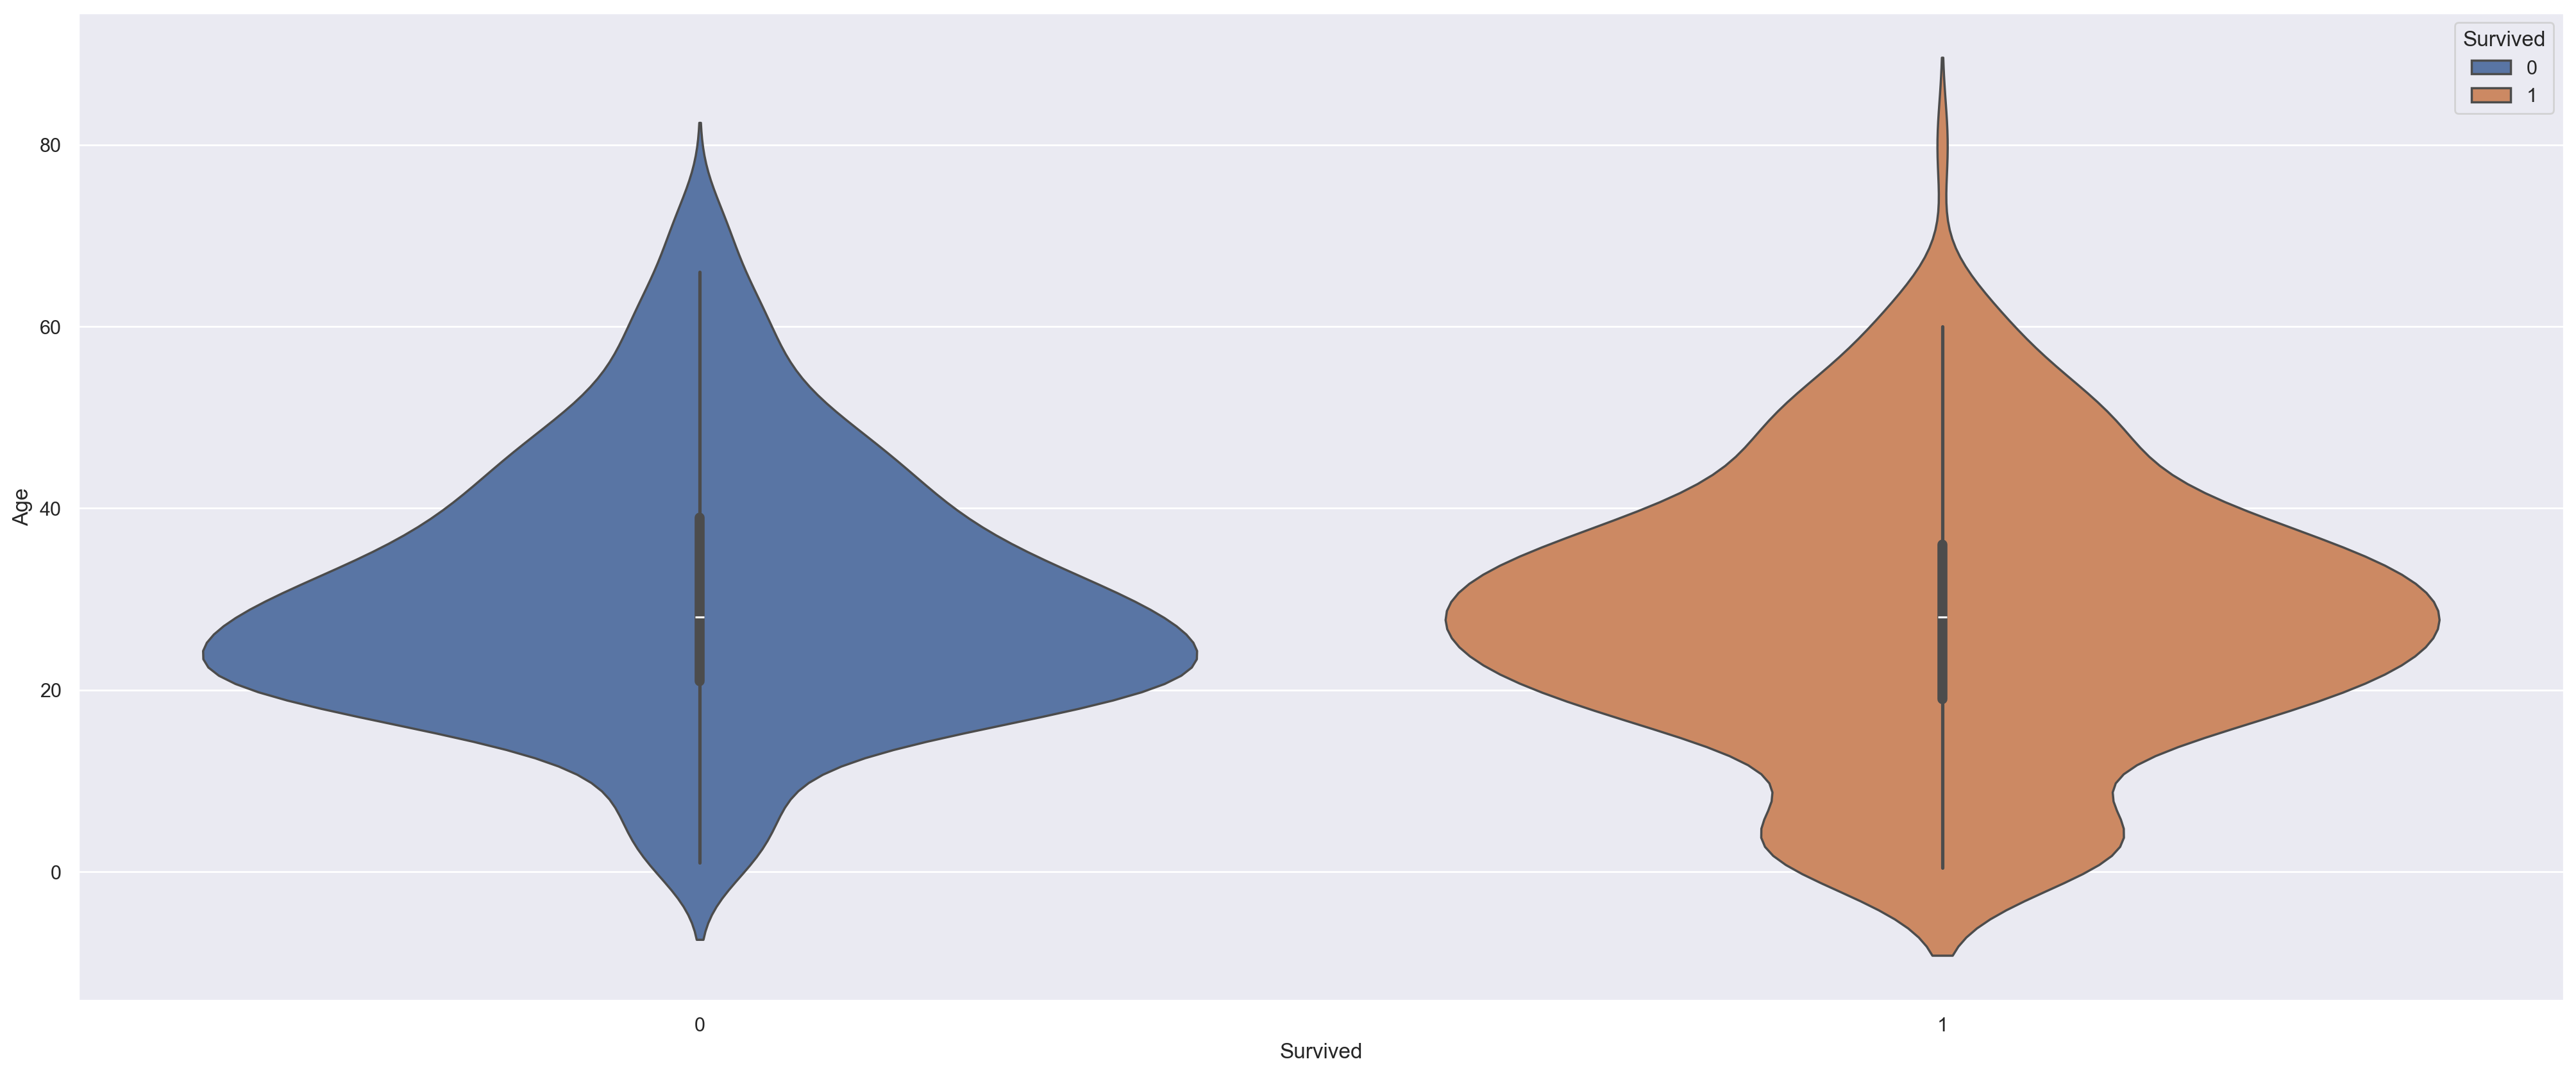

In [82]:
df = titanic_sub.copy()
df["Survived"] = LabelEncoder().fit_transform(y)
sns.violinplot(df, x='Survived', y='Age', hue="Survived")
plt.show()

Come possiamo vedere i violini mostrano distribuzioni d'età molto simili, per i deceduti (0) e i sopravvissuti (1), con un'accentuazione per i passeggeri più giovani e più anziani nel gruppo dei sopravvissuti.

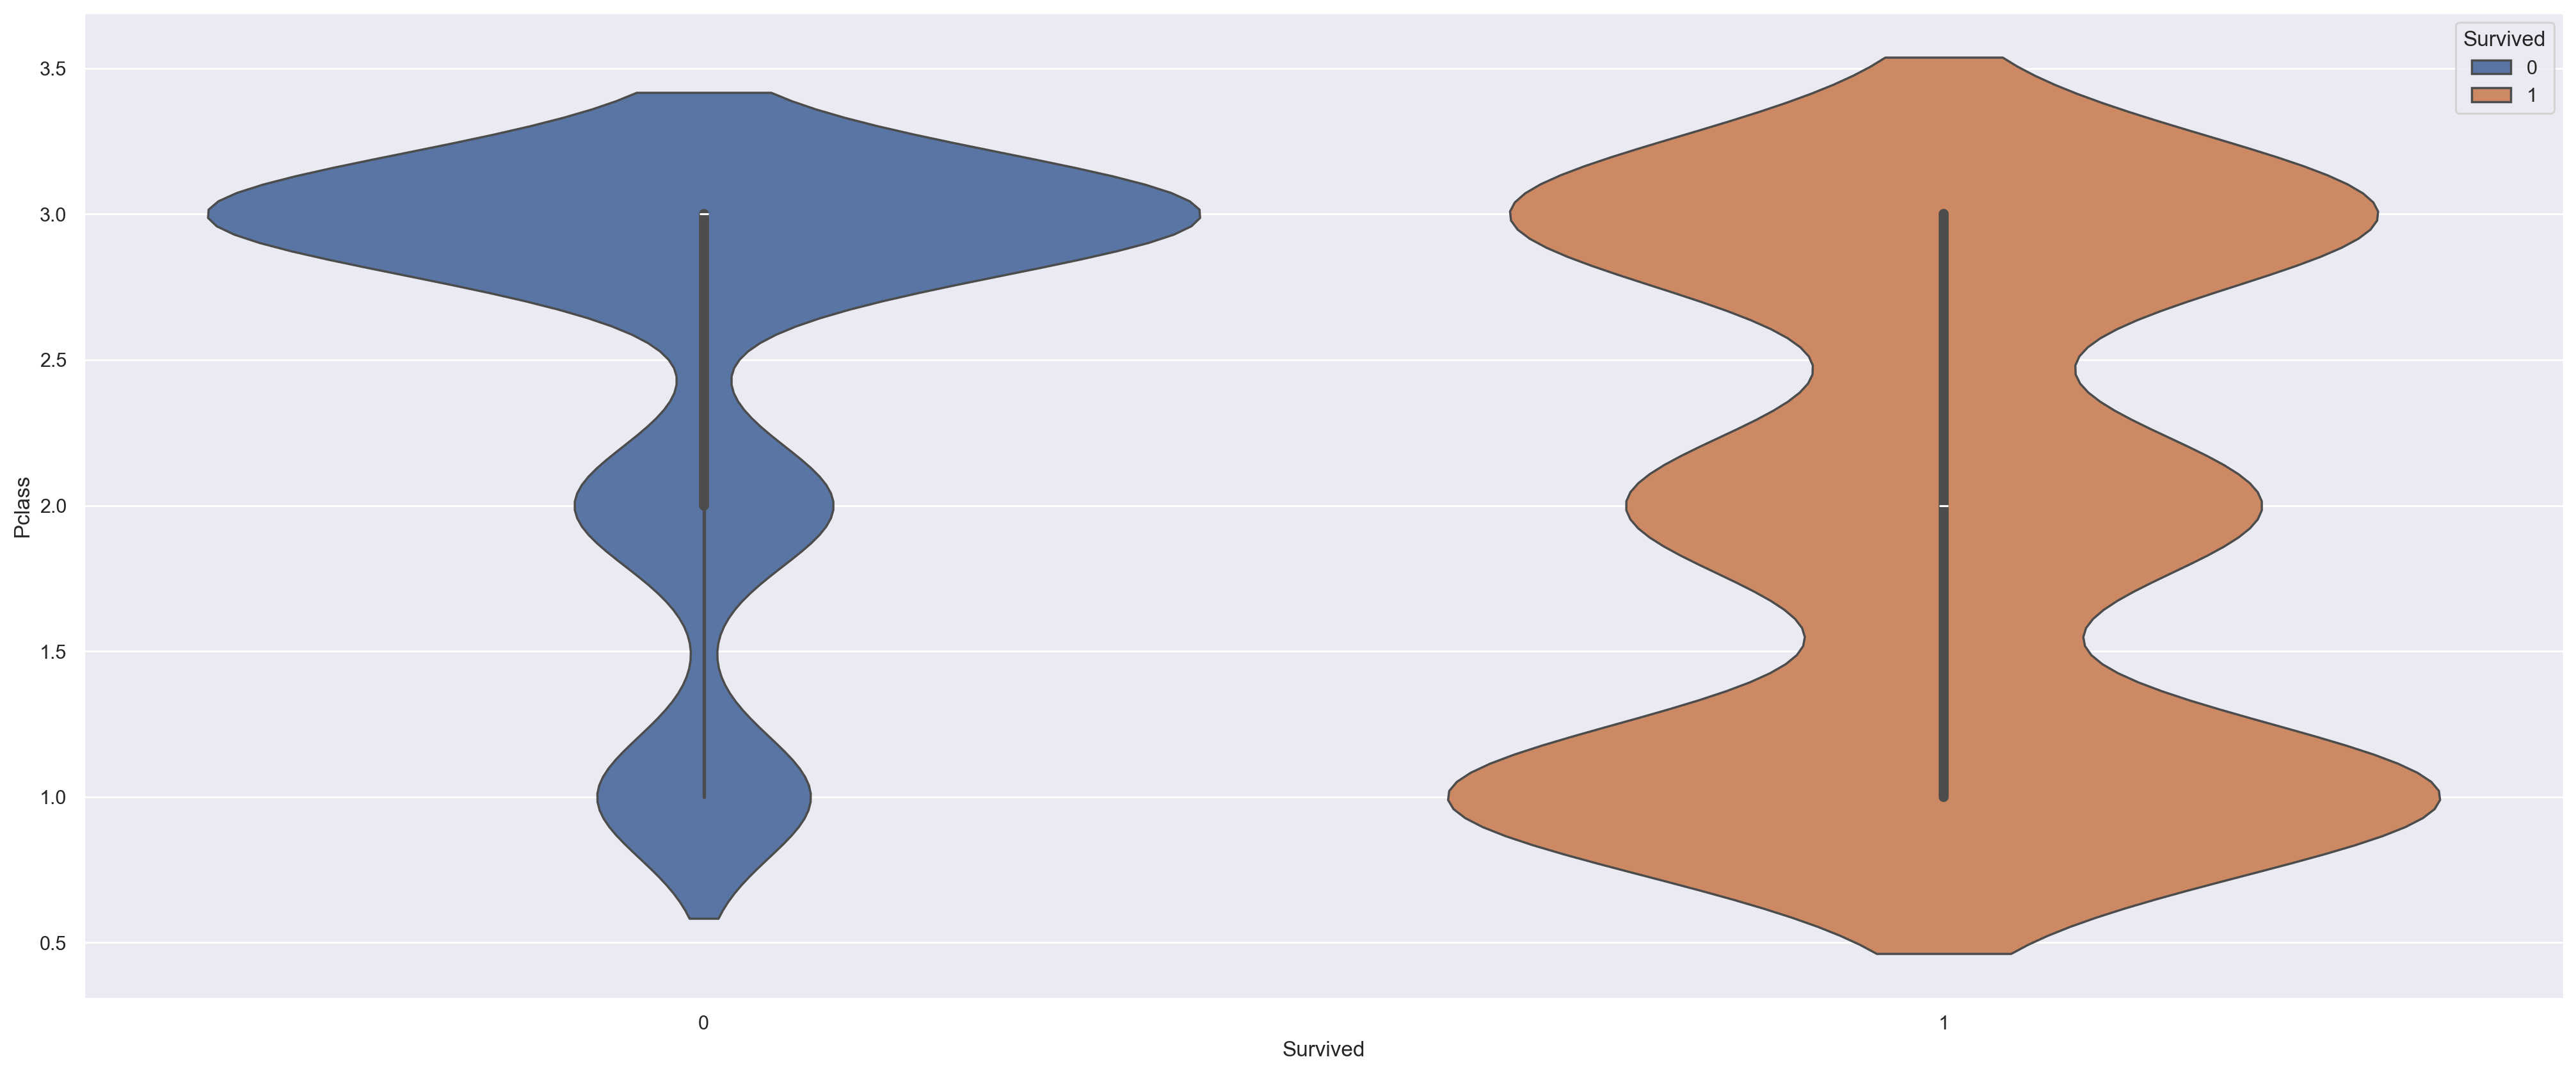

In [83]:
df = titanic_sub.copy()
df["Survived"] = LabelEncoder().fit_transform(y)
sns.violinplot(df, x='Survived', y='Pclass', hue="Survived")
plt.show()

La classe del biglietto fu un fattore determinante per la sopravvivenza nel disastro del Titanic, come illustrato dal grafico

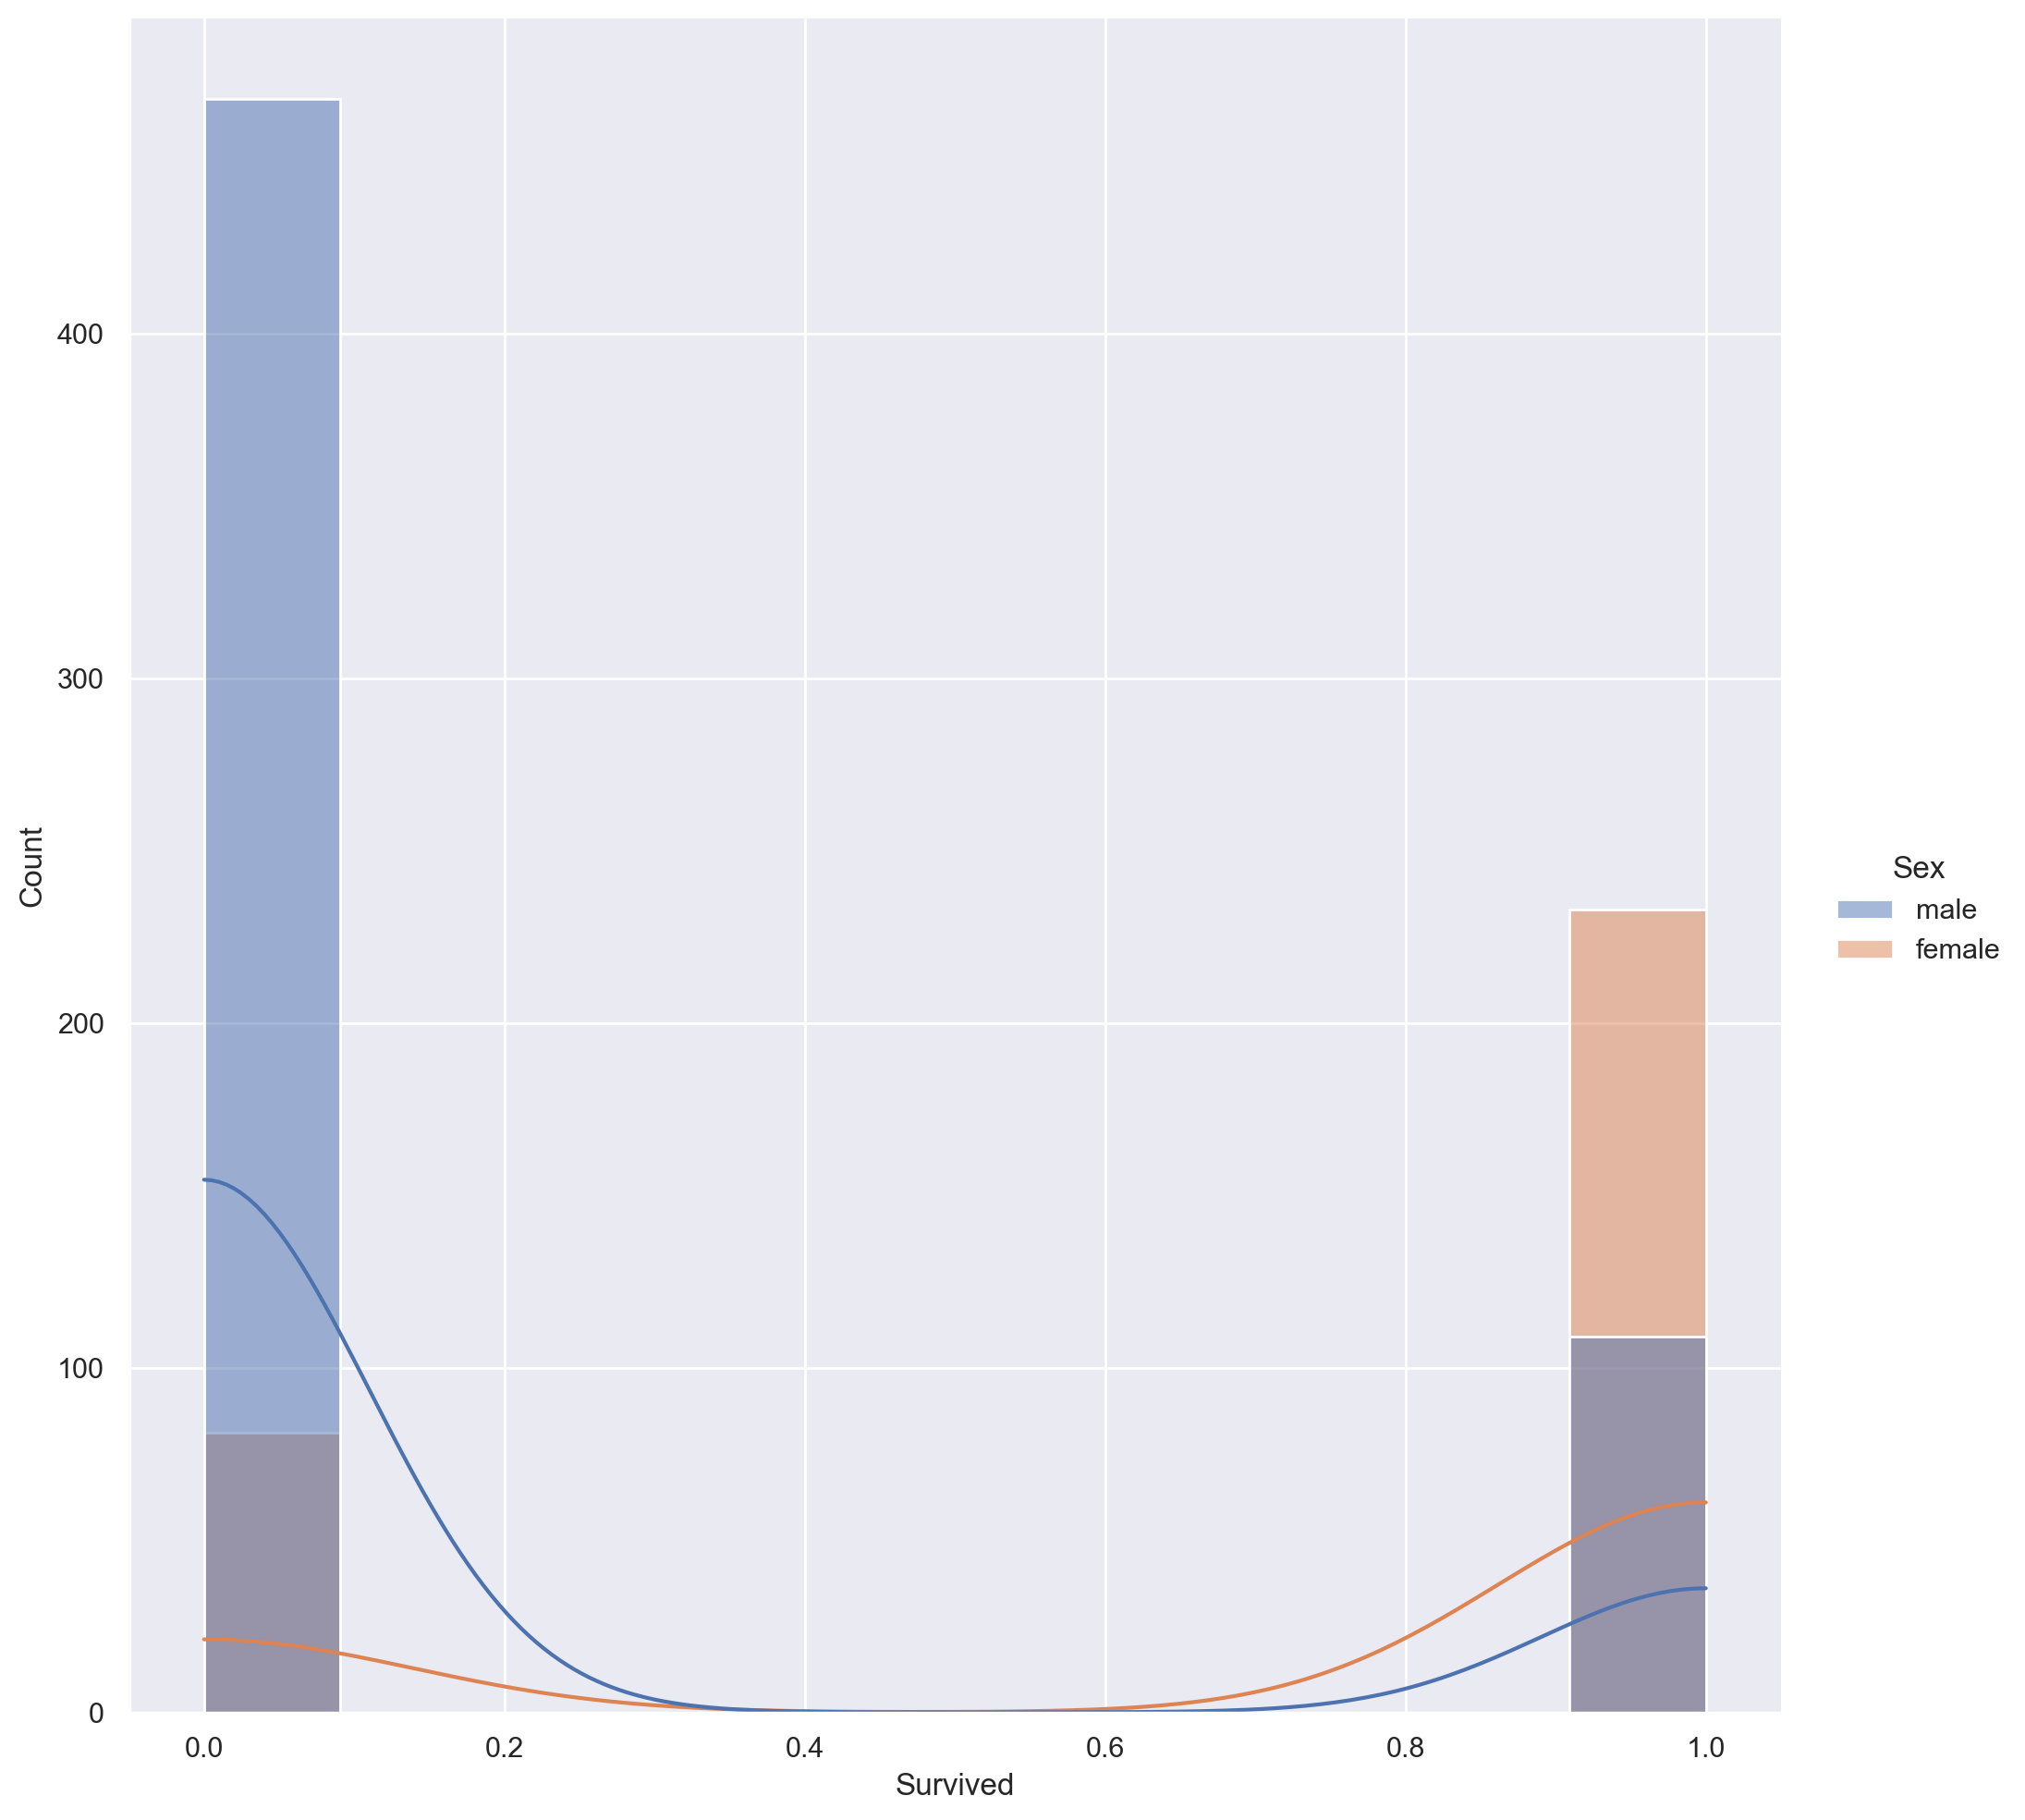

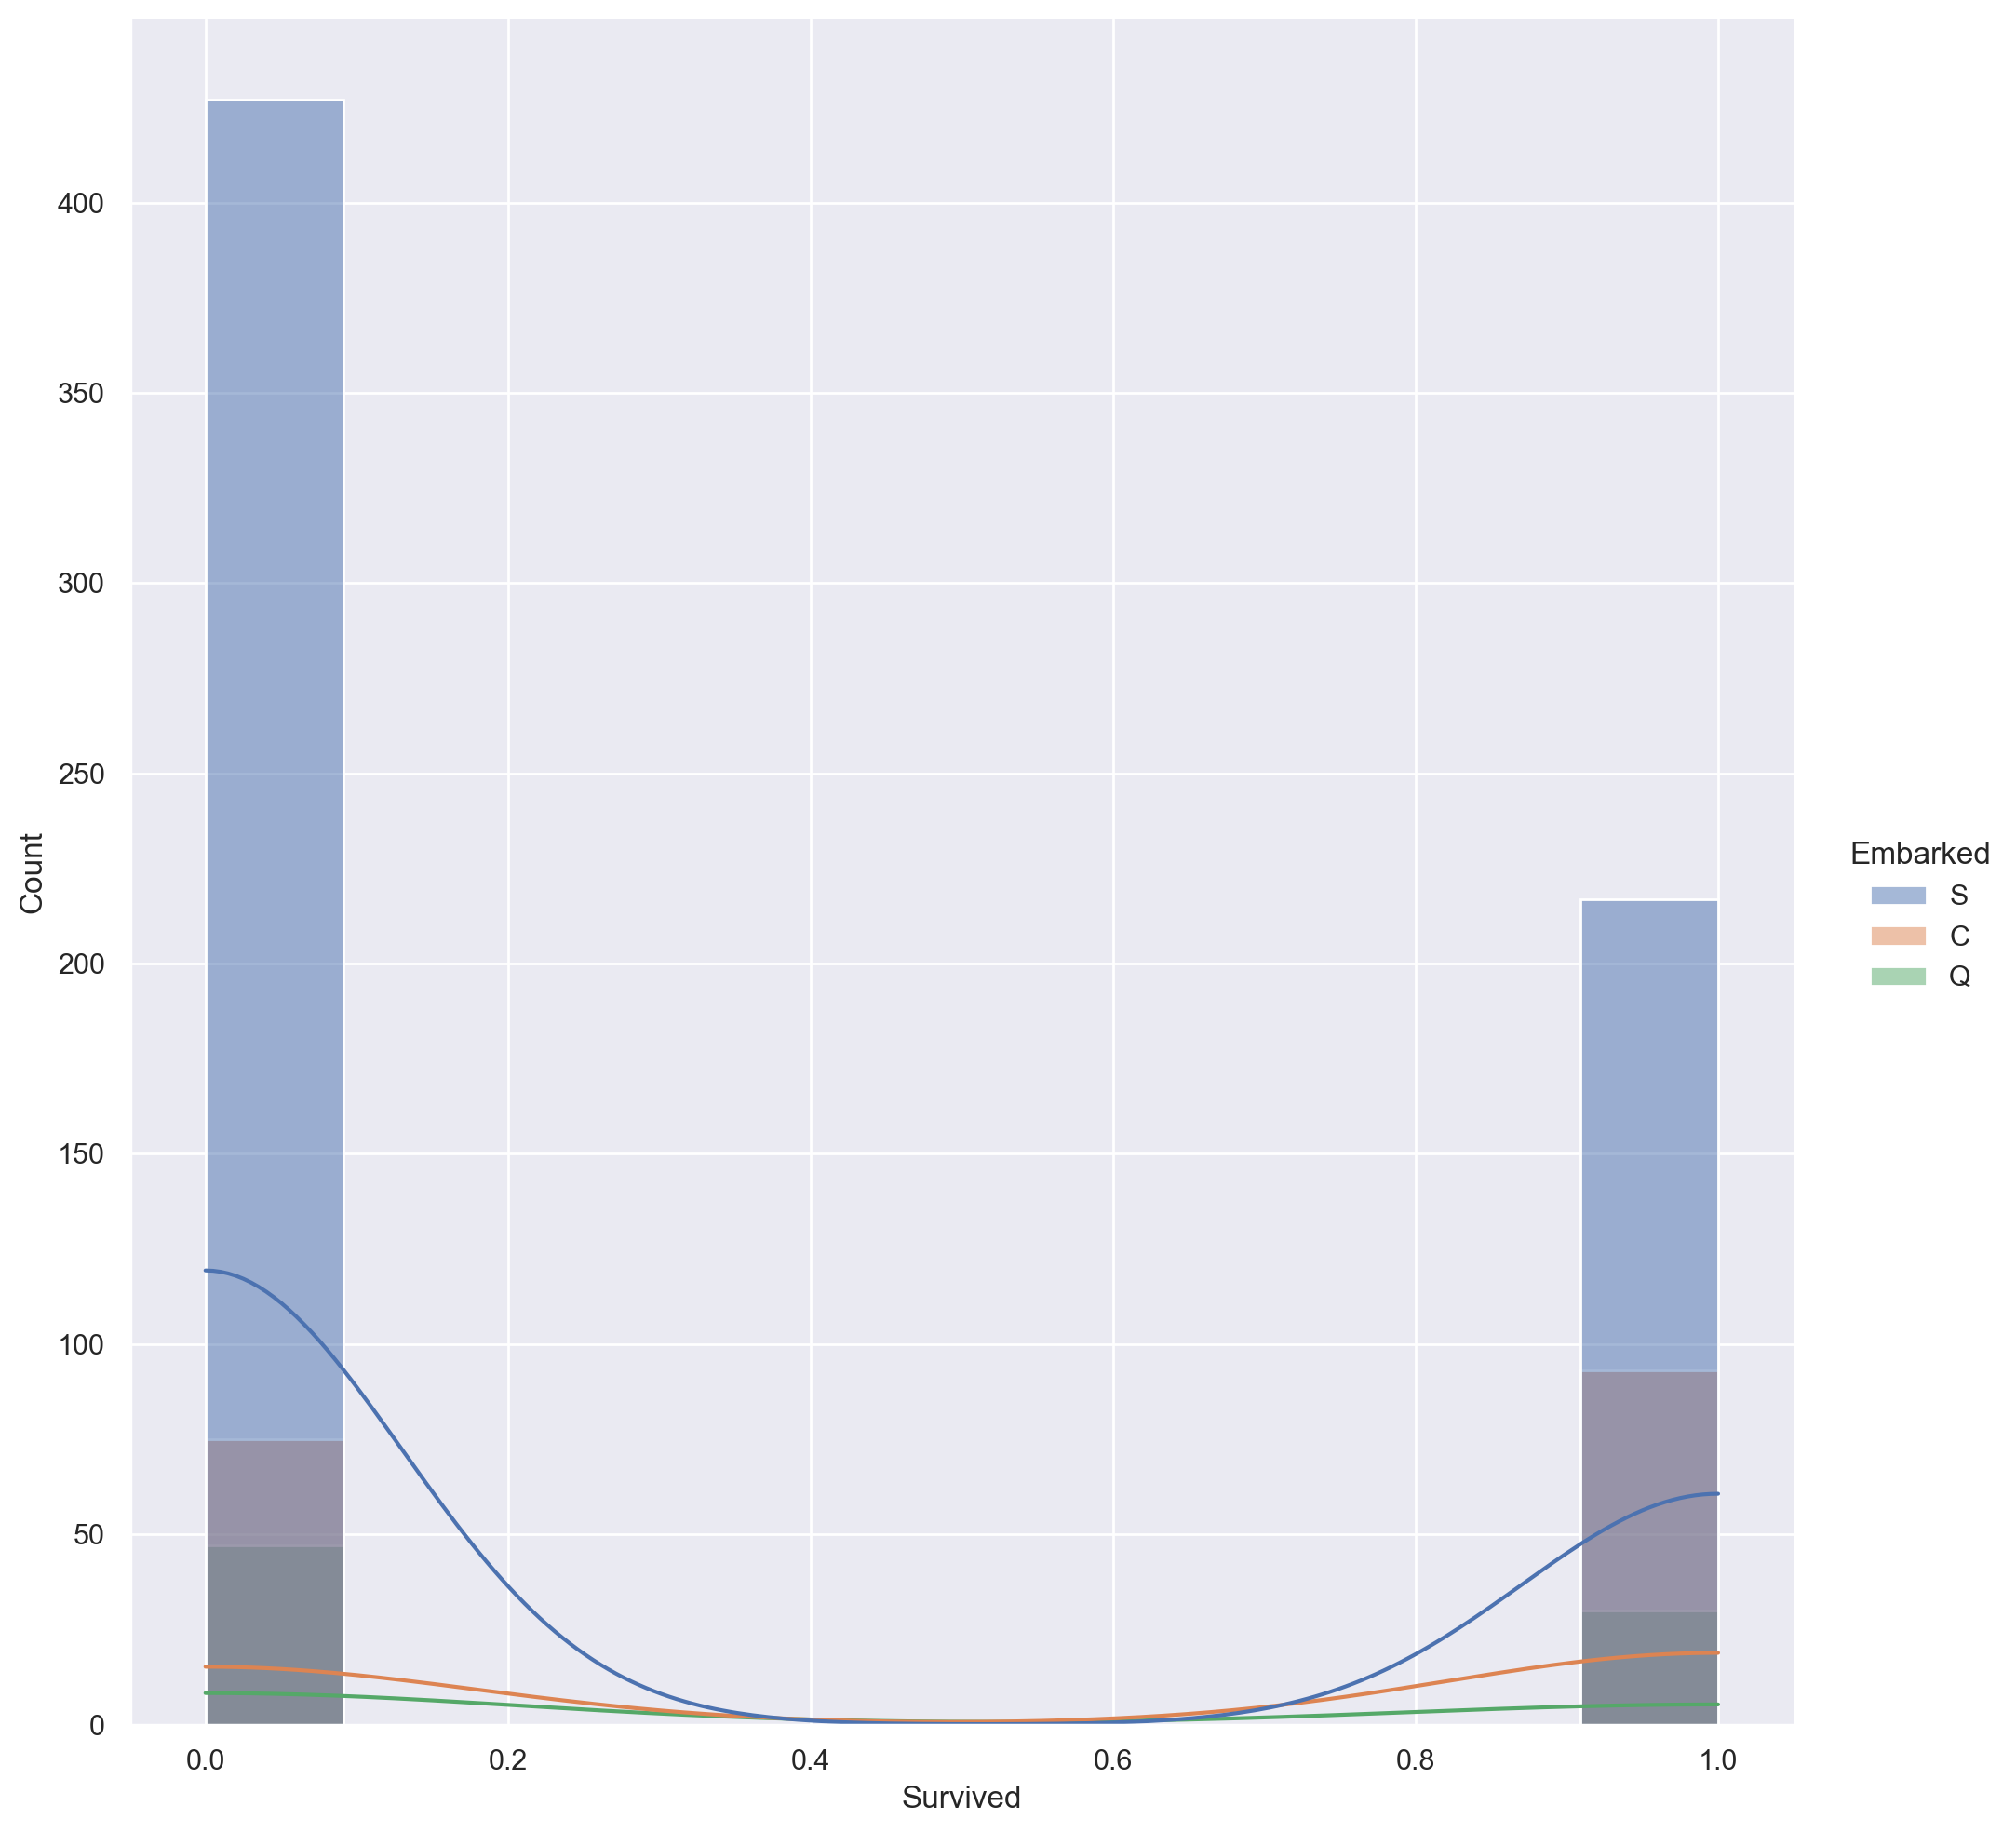

In [84]:
for col in categorical_variables:
    sns.displot(titanic_sub, x="Survived", hue=col, kde=True, height=10)
    plt.show()


Analizzando i grafici, emerge una netta tendenza alla non sopravvivenza dei passeggeri maschi e quelli imbarcati a Southampton ('S') porto noto per la sua elevata presenza di terza classe ed equipaggio. Questo conferma che, durante il disastro, fu data priorità a donne, bambini ed anziani.

# In conclusione
Diamo uno sguardo ai tassi di sopravvivenza in base alle classi del biglietto, al sesso e al porto d'imbarco, riassumendo le principali tendenze osservate.

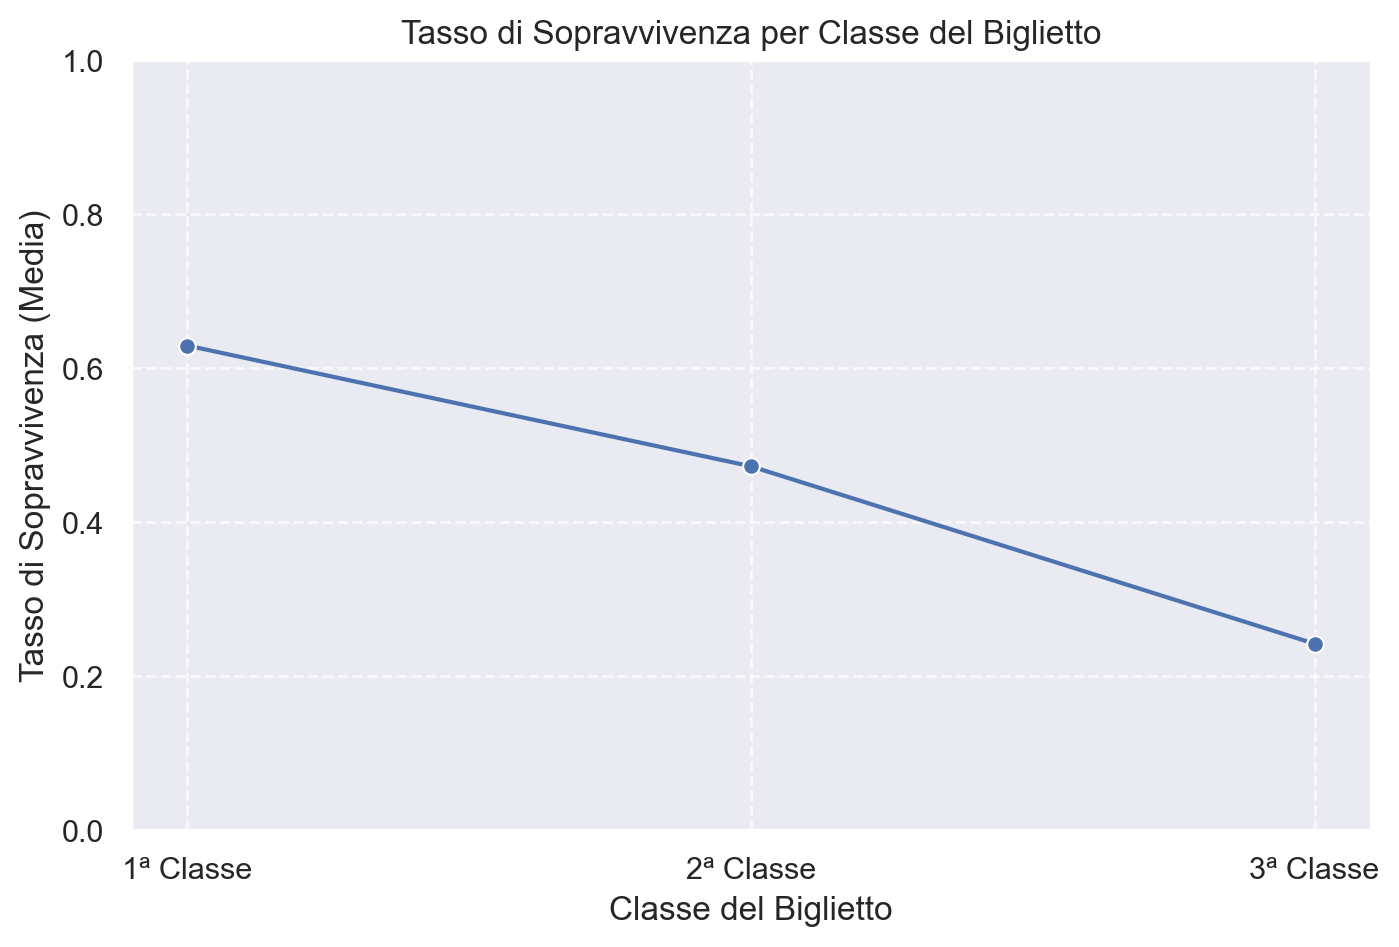

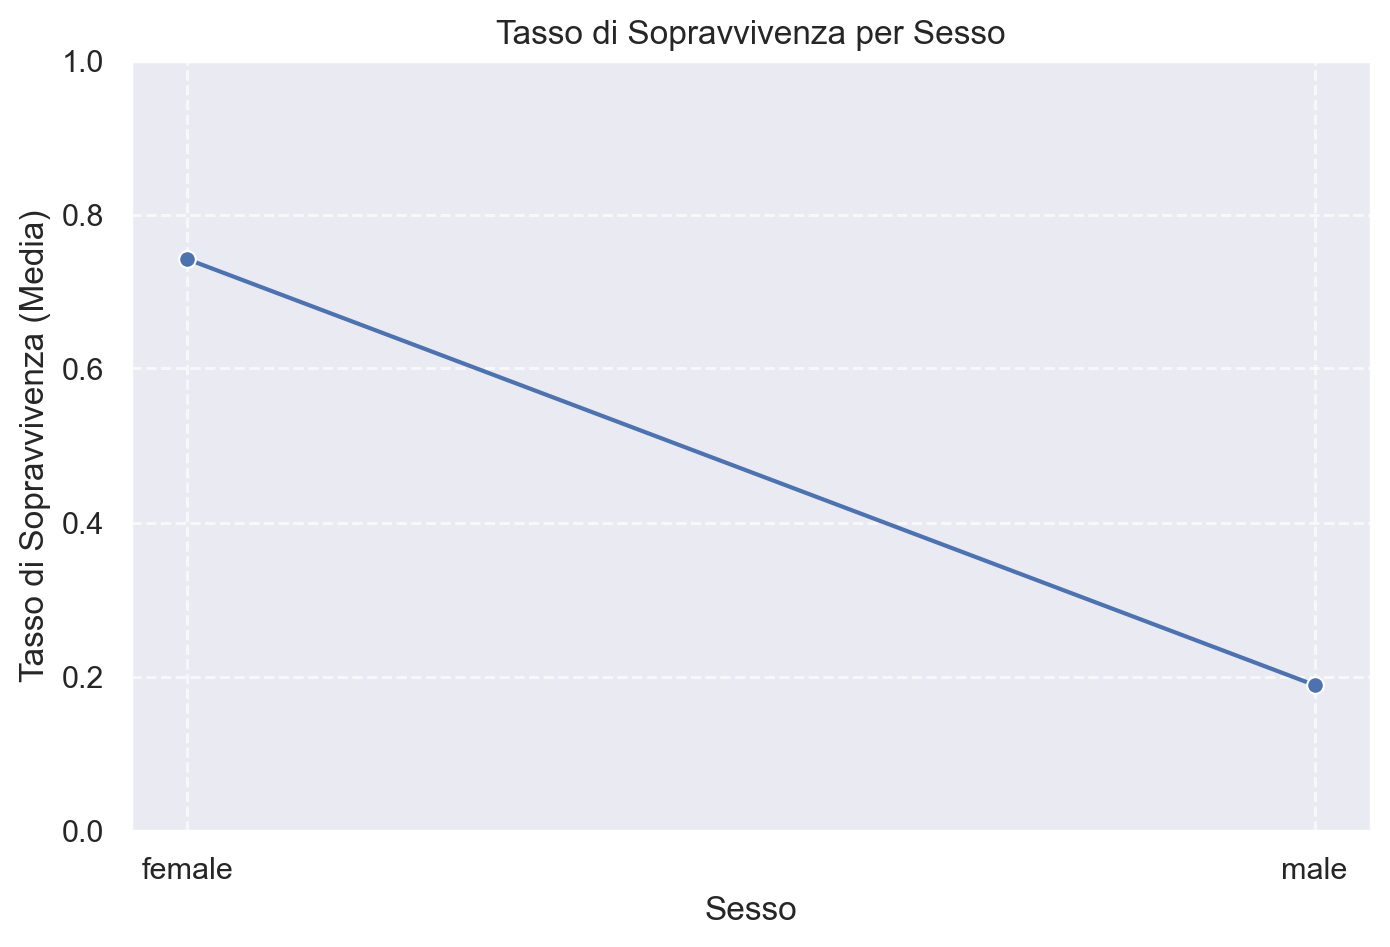

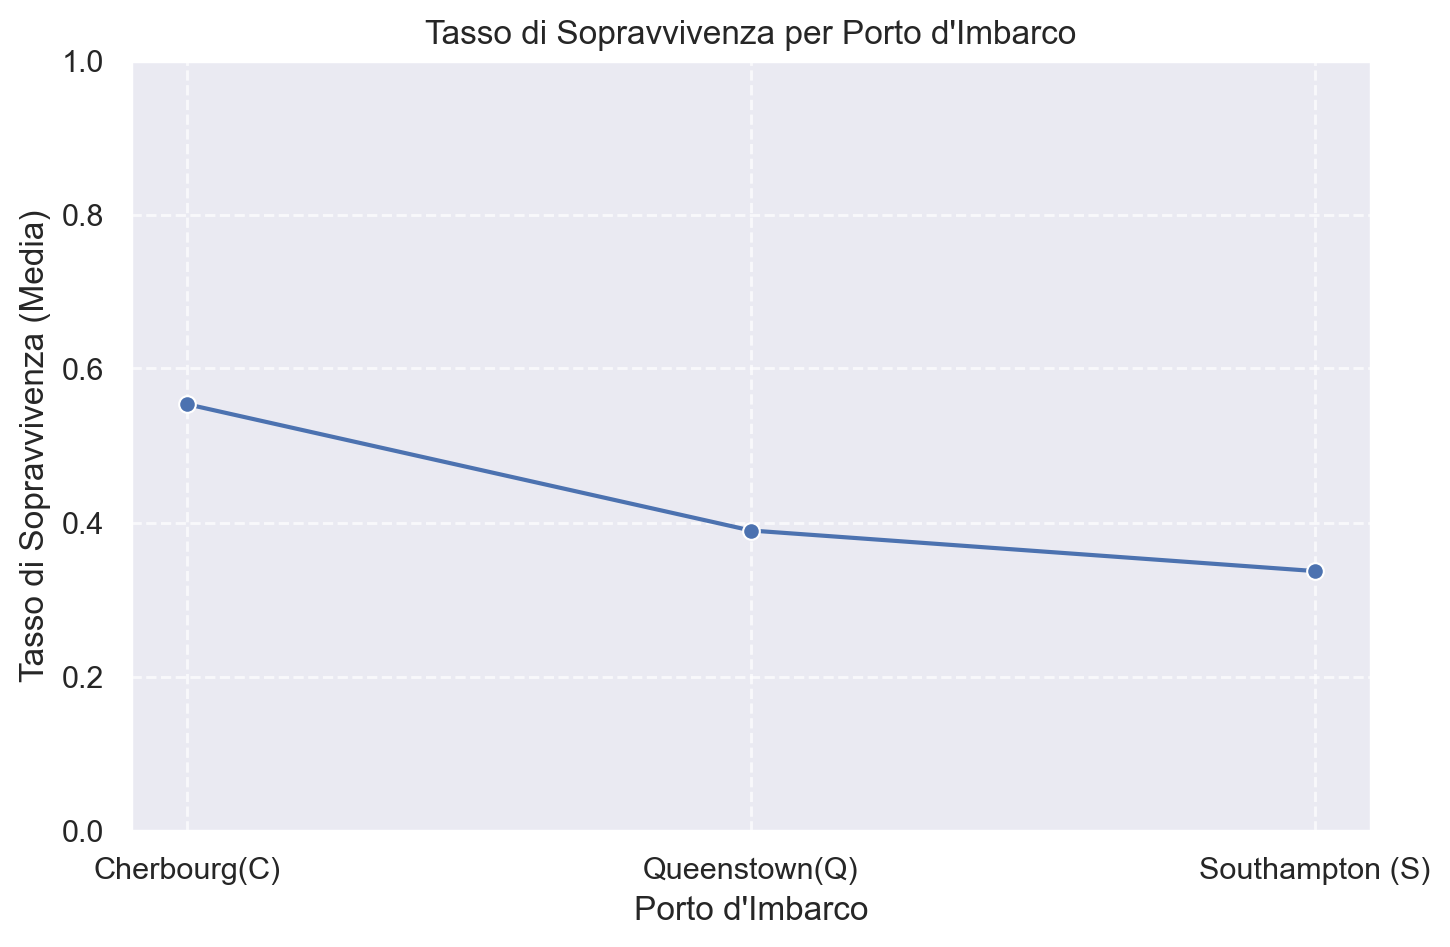

In [85]:
survival_rate_by_pclass = df.groupby('Pclass')['Survived'].mean().reset_index()

plt.figure(figsize=(8, 5))
sns.lineplot(data=survival_rate_by_pclass, x='Pclass', y='Survived', marker='o')
plt.title('Tasso di Sopravvivenza per Classe del Biglietto')
plt.xlabel('Classe del Biglietto')
plt.ylabel('Tasso di Sopravvivenza (Media)')
plt.xticks(survival_rate_by_pclass['Pclass'])
plt.xticks([1, 2, 3], ['1ª Classe', '2ª Classe', '3ª Classe']) # Etichette per le classi
plt.ylim(0, 1) # Il tasso di sopravvivenza va da 0 a 1
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

# Puoi ripetere per Sex:
survival_rate_by_sex = df.groupby('Sex')['Survived'].mean().reset_index()
plt.figure(figsize=(8, 5))
sns.lineplot(data=survival_rate_by_sex, x='Sex', y='Survived', marker='o')
plt.title('Tasso di Sopravvivenza per Sesso')
plt.xlabel('Sesso')
plt.ylabel('Tasso di Sopravvivenza (Media)')
plt.ylim(0, 1)
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

# E per Embarked:
survival_rate_by_embarked = df.groupby('Embarked')['Survived'].mean().reset_index()
plt.figure(figsize=(8, 5))
sns.lineplot(data=survival_rate_by_embarked, x='Embarked', y='Survived', marker='o')
plt.title('Tasso di Sopravvivenza per Porto d\'Imbarco')
plt.xlabel('Porto d\'Imbarco')
plt.ylabel('Tasso di Sopravvivenza (Media)')
plt.xticks(['C', 'Q', 'S'], ['Cherbourg(C)', 'Queenstown(Q)', 'Southampton (S)']) # Etichette per i porti
plt.ylim(0, 1)
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()


Conclusa la nostra finestra sul controllo dei dati, possiamo andare avanti e gestirli. 

# Gestione dei valori nulli
Per gestirli dobbiamo trasformare le colonne contenenti valori nulli in numeriche per poi dare loro un valore.
Per le colonne categoriche, possiamo usare LabelEncoder per trasformare i valori in numeri e poi usare get_dummies per trasformare le colonne categoriche in variabili dummy.

In [87]:
null_cols = titanic_sub.columns[titanic_sub.isnull().any()].tolist()
print("Colonne con valori nulli:", null_cols)

# Trasforma le colonne categoriche in numeriche (solo quelle con valori nulli)
for col in null_cols:
    if titanic_sub[col].dtype == 'object':
        le = LabelEncoder()
        titanic_sub[col] = le.fit_transform(titanic_sub[col].astype(str))

Colonne con valori nulli: ['Age']


# Definizione e scelta degli imputer
Ora possiamo testare le tecniche di imputazione e decidere quale funziona meglio.

Prima di tutto apriamo un dizionario con gli imputer che vogliamo testare:

In [88]:
# Definizione degli imputers
imputers = {
    "Media": SimpleImputer(strategy="mean"),
    "Mediana": SimpleImputer(strategy="median"),
    "Moda": SimpleImputer(strategy="most_frequent"),
    "Costante (0)": SimpleImputer(strategy="constant", fill_value=0),
    "KNN (k=2)": KNNImputer(n_neighbors=2),
    "KNN (k=5)": KNNImputer(n_neighbors=5),
    "KNN (k=10)": KNNImputer(n_neighbors=10),
    "KNN (k=25)": KNNImputer(n_neighbors=25),
    "Iterative (default)": IterativeImputer(random_state=0),
    "Iterative (max_iter=10)": IterativeImputer(max_iter=10, random_state=0)
}

# Definiamo una funzione per applicare gli imputers
L'obiettivo è quello di testare diversi imputers e valutare le loro performance: 

In [89]:
def test_imputers_with_models(X, y, imputers, test_size=0.25, random_state=0):
    """
    Confronta diversi imputers per riempire i valori nulli, basandosi sull'accuratezza del modello.

    Args:
        X (pd.DataFrame): Dataset con feature.
        y (pd.Series): Target del dataset.
        imputers (dict): Dizionario di imputers da testare.
        test_size (float): Percentuale del dataset da usare come test set.
        random_state (int): Seed per la randomicità.

    Returns:
        tuple: (imputer_migliore, risultati), dove `imputer_migliore` è l'imputer con la migliore accuratezza
               e `risultati` è un dizionario con l'accuratezza per ogni imputer.
    """
    results = {}
    best_imputer = None
    best_accuracy = 0

    for name, imputer in imputers.items():
        # Creazione di una copia del dataset per evitare modifiche in-place
        X_copy = X.copy()

        # Applicazione dell'imputer
        X_copy.iloc[:, :] = imputer.fit_transform(X_copy)

        # Suddivisione del dataset
        X_train, X_test, y_train, y_test = train_test_split(X_copy, y, test_size=test_size, random_state=random_state)

        # Addestramento del modello
        model = DecisionTreeClassifier(random_state=random_state)
        model.fit(X_train, y_train)

        # Predizioni e calcolo dell'accuratezza
        y_pred = model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)

        # Salvataggio del risultato
        results[name] = accuracy

        # Aggiornamento del miglior imputer
        if accuracy > best_accuracy:
            best_imputer = imputer
            best_accuracy = accuracy

    # Stampa dei risultati
    print("\nConfronto degli imputers:")
    for imputer, accuracy in results.items():
        print(f"{imputer:<25} Accuratezza: {accuracy:.2f}")

    # Stampa del miglior imputer
    print(f"\nMiglior imputer: {best_imputer} con Accuratezza: {max(results.values()):.2f}")
    print("-------------------------------------------------------")

    return best_imputer, results


Ora che abbiamo definito la funzione possiamo richiamarla e osservarne i risultati.

In [90]:
# Esegui il confronto su tutte le colonne con valori nulli
X_nulls = titanic_sub[null_cols]
best_imputer, imputer_results = test_imputers_with_models(X_nulls, titanic_sub['Survived'], imputers)


Confronto degli imputers:
Media                     Accuratezza: 0.64
Mediana                   Accuratezza: 0.64
Moda                      Accuratezza: 0.64
Costante (0)              Accuratezza: 0.64
KNN (k=2)                 Accuratezza: 0.64
KNN (k=5)                 Accuratezza: 0.64
KNN (k=10)                Accuratezza: 0.64
KNN (k=25)                Accuratezza: 0.64
Iterative (default)       Accuratezza: 0.64
Iterative (max_iter=10)   Accuratezza: 0.64

Miglior imputer: SimpleImputer() con Accuratezza: 0.64
-------------------------------------------------------


Dai risultati, possiamo vedere che non esiste un imputer che funziona meglio di tutti gli altri in modo assoluto, quindi per mantenere il processo semplice useremo la Media.

In [91]:
# Applica il miglior imputer a tutte le colonne con valori nulli
for col in null_cols:
    titanic_sub[col] = best_imputer.fit_transform(titanic_sub[[col]])

# Unificazione delle colonne
Ora che le abbiamo riempite possiamo dummificare le restanti colonne

In [92]:
# Applico il get_dummies
titanic_sub = pd.get_dummies(titanic_sub, columns=['Sex', 'Embarked', 'Pclass'], drop_first=True)
titanic_sub.info(memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Age          891 non-null    float64
 2   Survived     891 non-null    int64  
 3   Sex_male     891 non-null    bool   
 4   Embarked_1   891 non-null    bool   
 5   Embarked_2   891 non-null    bool   
 6   Embarked_3   891 non-null    bool   
 7   Pclass_2     891 non-null    bool   
 8   Pclass_3     891 non-null    bool   
dtypes: bool(6), float64(1), int64(2)
memory usage: 26.2 KB


# Split in train and ,validation e test set
Definiamo le feature e il target di questo test per darci un obiettivo, suddividiamo il dataset e ne verichiamo le dimensioni finali

In [93]:
# Definizione delle feature e del target
X = titanic_sub.drop(columns=['Survived', 'PassengerId'])  # Rimuoviamo anche PassengerId
y = titanic_sub['Survived']

# Suddivisione del dataset in training, validation e test set
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

# Suddivisione del training set in training e validation set
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.25, random_state=0)

# Verifica delle dimensioni dei set
print(f"Training set size: {X_train.shape[0]}")
print(f"Validation set size: {X_val.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")
print("-------------------------------------------------------")

Training set size: 501
Validation set size: 167
Test set size: 223
-------------------------------------------------------


# Baseline model
Ora possiamo definire un modello base da poter "battere" con il modello che successivamente creeremo provando a migliorare i risultati in base alle nostre necessità.

In [94]:
# Modello baseline: Logistic Regression
model = LogisticRegression(max_iter=1000, random_state=42)
model.fit(X_train, y_train)

# Predizioni
y_pred = model.predict(X_test)

# Valutazione del modello
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Valutazione del modello di base
print(f'Baseline Model Accuracy: {accuracy:.2f}')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1 Score: {f1:.2f}')
print()  # Andare a capo

Baseline Model Accuracy: 0.80
Precision: 0.73
Recall: 0.73
F1 Score: 0.73



# Modello Decision Tree
Per cominciare le nostre migliorie usiamo un Decision Tree Classifier.
Partiamo con l'inizializziazione delle variabili per poi testare varie profondità dell'Albero cercando di trovare la migliore.


In [95]:
# Modello Decision Tree
# Inizializzazione delle variabili per il miglior modello
best_model = None
best_depth = None
best_accuracy = 0
# Lista delle profondità da testare
depths = [2, 5, 10, 25, None]

# Iterazione sulle diverse profondità
for depth in depths:
    # Creazione e addestramento del modello
    model = DecisionTreeClassifier(max_depth=depth, random_state=0)
    model.fit(X_train, y_train)

    # Predizioni sul validation set
    y_val_pred = model.predict(X_val)

    # Calcolo delle metriche
    accuracy = accuracy_score(y_val, y_val_pred)
    precision = precision_score(y_val, y_val_pred)
    recall = recall_score(y_val, y_val_pred)
    f1 = f1_score(y_val, y_val_pred)

    # Stampa delle metriche
    print(f"Profondità: {depth if depth else 'max'}")
    print(f"  Accuratezza: {accuracy:.2f}")
    print(f"  Precision: {precision:.2f}")
    print(f"  Recall: {recall:.2f}")
    print(f"  F1 Score: {f1:.2f}")
    print()  # Andare a capo

    # Aggiornamento del miglior modello
    if accuracy > best_accuracy:
        best_model = model
        best_depth = depth
        best_accuracy = accuracy



Profondità: 2
  Accuratezza: 0.79
  Precision: 0.95
  Recall: 0.53
  F1 Score: 0.68

Profondità: 5
  Accuratezza: 0.82
  Precision: 0.93
  Recall: 0.61
  F1 Score: 0.74

Profondità: 10
  Accuratezza: 0.81
  Precision: 0.83
  Recall: 0.69
  F1 Score: 0.75

Profondità: 25
  Accuratezza: 0.80
  Precision: 0.80
  Recall: 0.69
  F1 Score: 0.74

Profondità: max
  Accuratezza: 0.80
  Precision: 0.80
  Recall: 0.69
  F1 Score: 0.74



Prendiamo ora il modello migliore e in caso di parità quello con minore profondità

In [96]:
# Test del miglior modello sul test set
print(f"Miglior modello: Profondità {best_depth if best_depth else 'max'} con Accuratezza {best_accuracy:.2f} sul validation set")
print("-------------------------------------------------------")

Miglior modello: Profondità 5 con Accuratezza 0.82 sul validation set
-------------------------------------------------------


Testiamo le metriche del modello su cui abbiamo appena lavorato

In [97]:
y_test_pred = best_model.predict(X_test)

# Calcolo delle metriche sul test set
test_accuracy = accuracy_score(y_test, y_test_pred)
test_precision = precision_score(y_test, y_test_pred)
test_recall = recall_score(y_test, y_test_pred)
test_f1 = f1_score(y_test, y_test_pred)

# Stampa delle metriche sul test set
print("\nValutazione sul test set:")
print(f"  Accuratezza: {test_accuracy:.2f}")
print(f"  Precision: {test_precision:.2f}")
print(f"  Recall: {test_recall:.2f}")
print(f"  F1 Score: {test_f1:.2f}")


Valutazione sul test set:
  Accuratezza: 0.81
  Precision: 0.85
  Recall: 0.61
  F1 Score: 0.71


# Valutazione dei modelli
Qui andremo a confrontare direttamente i 2 modelli che abbiamo creato e verificare se ci sono stati miglioramenti e se ne siamo soddisfatti

In [99]:
# Analisi numerica per il confronto tra i modelli
print("\nConfronto delle prestazioni tra il modello baseline e il miglior modello:")

# Metriche del modello baseline
baseline_metrics = {
    "Accuratezza": accuracy,
    "Precision": precision,
    "Recall": recall,
    "F1 Score": f1
}

# Metriche del miglior modello
best_model_metrics = {
    "Accuratezza": test_accuracy,
    "Precision": test_precision,
    "Recall": test_recall,
    "F1 Score": test_f1
}

# Stampa del confronto
print(f"{'Metrica':<15}{'Baseline':<15}{'Miglior Modello':<15}{'Differenza':<15}")
for metric, baseline_value in baseline_metrics.items():
    best_value = best_model_metrics[metric]
    difference = best_value - baseline_value
    print(f"{metric:<15}{baseline_value:<15.2f}{best_value:<15.2f}{difference:<15.2f}")
print("-------------------------------------------------------")



Confronto delle prestazioni tra il modello baseline e il miglior modello:
Metrica        Baseline       Miglior ModelloDifferenza     
Accuratezza    0.80           0.81           0.02           
Precision      0.80           0.85           0.05           
Recall         0.69           0.61           -0.08          
F1 Score       0.74           0.71           -0.03          
-------------------------------------------------------


# Risultati
Come possiamo notare ci sono sia miglioramenti che peggioramenti, ragionando sul nostro obiettivo e l'ambiente del dataset possiamo esserne compiaciuti calcolando che segnalare un passeggero come morto alla leggera non è una cosa delle migliori.

Però si può anche ragionare sul fatto che date le differenze fra i modelli in base alle prorità che si hanno il basemodel è comunque competitivo e bilanciato, mantenendo comunque delle statistiche ottime e una migliore Recall.



/// DIVISORIO ///


Allora, ci sono un po' di cose:

Manca tutta la parte di analisi numerica: cosa ti fa dire che occorre usare il KNNImputer? Quanti valori nulli ci sono? Perché questa è la scelta giusta?
**Ho provato a cambiare approccio quindi mi permetto di togliere le mie vecchie spiegazioni, non so se ho incluso in modo corretto l'analisi numerica ma guardando online non mi sembra di essere lontano, ho aggiunto sia un confronto fra basemodel e modellofinale, sia un confronto fra vari imputer, effettivamente ora l'imputer cambia a confronto a prima come ho constatato con i risultati, ma è anche probabile che data la piccola quantità di dati non ci siano differenze tali da avere un imputer nettamente migliore.

No, la scelta va giustificata numericamente (tra l'altro potevi anche togliere i valori nulli). Concretamente prendi il validation dataset, e valuti il baseline model su tutte e tre le possibilità e prendi la migliore. La tua giustificazione a priori può funzionare per selezionare 3,4 scelte quando ne hai 100 disponibili. Poi, per raffinare la scelta, si valida sempre.


Questo è un esempio, ma in generale ogni scelta che fai se presentata così è arbitraria: occorre una giustificazione numerica che venga dall'analisi dati.
**Provo a riassumere un po le mie decisione e il processo,
Ho stampato i valori nulli presenti nel dataset per prenderne conoscenza, dopodichè ho selezionato le colonne che presentavano valori nulli (nel mio caso AGE,EMBARKED), e le ho "riempite" con dei valori provando diversi imputer, la scelta degli imputer è stata fatta tenendo a mente l'utilizzo di un albero decisionale mantenendo comunque per ogni imputer un vario range di valori (provando diversi Simple,KNN, etc) fatto ciò ho potuto constatare che per un motivo di mancanza di dati o altro fra i vari imputer non sono presenti differenze di accuratezza, il valore che per logica mi è sembrato fosse il piu sensato seguire/selezionare data la traccia d'esame.
Con l'Imputer selezionato e diviso il set originale in train,validarion e test ho creato un basemodel da usare come punto di riferimento per poi testare le diverse profondità dell'albero facendo vedere a schermo dove possiamo vedere e confrontare i vari valori, come richiesto però ho preso l'accuratezza migliore e attuato il test sul set, in fine ho stampato il confronto numerico fra i 2 modelli presi il che ci permette di identificare all'incirca gli stessi ragionamenti dei precedenti tentativi, dove notiamo un miglioramento in accuratezza e precisioni, ma un calo in recall e f1, il che potremmo esserne compiaciuti calcolando che stiamo lavorando nel dataset del titanic e segnalare un passeggero come morto alla leggera non è una cosa delle migliori, però si può anche ragionare sul fatto che date le differenze fra i modelli in base alle prorità che si hanno il basemodel è comunque competitivo e bilanciato, mantenendo comunque delle statistiche ottime ma una migliore Recall.

Le soglie per creare gli insiemi di training, test e validazione, come le hai scelte? (Tra l'altro nella presentazione hai scritto che il validation set è estratto dal test, non dal train).
**Per le soglie ho seguito le direzioni di dividere in 75/25 e dividere ulteriormente il train in un altro 75/25. Riguardo la presentazione ho cambiato test in train come doveva essere.

Perché hai scelto l'accuracy come metrica? Anche questa è una scelta che va giustificata.
**L'esercizio dice che la metrica di valutazione è l'accuratezza quindi ho pensato non fosse opportuno aggiungere altri dati, aggiungerò il report di classificazione per una maggiore visione sui dati. Inoltre nonostante un basso valore di recall dato over valutazione dei passeggeri in sopravvissuti potrebbe essere accettabile dato il contesto, poiché valutare un passeggero come deceduto è piu grave.

Inoltre, la validazione non è qualcosa che ti veniva richiesta in questo esercizio, va bene farla, ma allora devi farla in un modo preciso: cosa mi diche che le tue scelte di validazione effettivamente migliorino le prestazioni del modello e soprattutto, di quanto? Per misurare questo occorre un *baseline model* che nel tuo caso manca.
**Ho lasciato solo il base e final model, aggiungenda una tabella con le "differenze" e cosa guadagna e cosa perde in valori

Il baseline è un modello semplice e interpretabile (tipo una logisti regression per i problemi di classificazione, o la linear regression per la regressione): il dummyC non si usa mai perché come hai visto non serve a granché.
L'obiettivo del baseline model è validare le tue scelte in maniera preliminare -> come abbiamo visto sopra, che imputer usare? scalare le variabili serve? che impatto ha? etc.

Spero di aver risposto a tutto ed essere stato esplicito nelle spiegazioni, grazie.

Va meglio, ma c'è ancora un po' di confusione sulle giustificazioni che mi aspetto da un data scientist.

So che può sembrare un atteggiamento pedante, ma queste correzioni sono le uniche occasioni di confronto tra noi e vorrei che ne traeste il massimo possibile.
**Non si preoccupi non è per niente pedante, probabilmente venendo da una base da informatico trovo difficoltà a capire certi concetti dato che il mio cervello va direttamente a "trova la risposta che funziona" e "se il codice funziona allora va bene" anzi mi scuso io per la mia testardaggine.

### Commento

Allora, meglio ma ancora non ci siamo. Mi manca tutta la parte di analisi preliminare. Mi stai presentando uno script non un progetto in cui io possa vedere che ragionamenti fai.

Se vuoi capire meglio cosa intendo, prova a dare uno sguardo a questo notebook.

https://github.com/oscar-defelice/DSAcademy-lectures/blob/master/Lectures_src/09.Final_project/projects/October2022_Tanzania/ProposedSolution/FinalModel_notebook.ipynb